In [5]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
import scipy.io
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim


seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

g = 9.81

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Utilizando o dispositivo:', device)

Utilizando o dispositivo: cpu


In [7]:
# Valores numéricos

mu_v = 1
zeta_v = 0.05
k_v = 1
gamma_v = 0.1
P_v = 0.08

In [8]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
A_dir = "/content/drive/MyDrive/Iniciação Cientifica/2023-2024/Python/BEPE/PINN/Dataset/A_dataset.txt"
B_dir = "/content/drive/MyDrive/Iniciação Cientifica/2023-2024/Python/BEPE/PINN/Dataset/B_dataset.txt"
Af_dir = "/content/drive/MyDrive/Iniciação Cientifica/2023-2024/Python/BEPE/PINN/Dataset/Af_dataset.txt"
Bf_dir = "/content/drive/MyDrive/Iniciação Cientifica/2023-2024/Python/BEPE/PINN/Dataset/Bf_dataset.txt"
X_dir = "/content/drive/MyDrive/Iniciação Cientifica/2023-2024/Python/BEPE/PINN/Dataset/X_dataset.txt"

In [10]:
A =np.loadtxt(A_dir)
B = np.loadtxt(B_dir)
Af = np.loadtxt(Af_dir)
Bf = np.loadtxt(Bf_dir)

X = np.loadtxt(X_dir)
X = 2*np.pi*X

In [11]:
A.shape, X.shape

((5174,), (5174,))

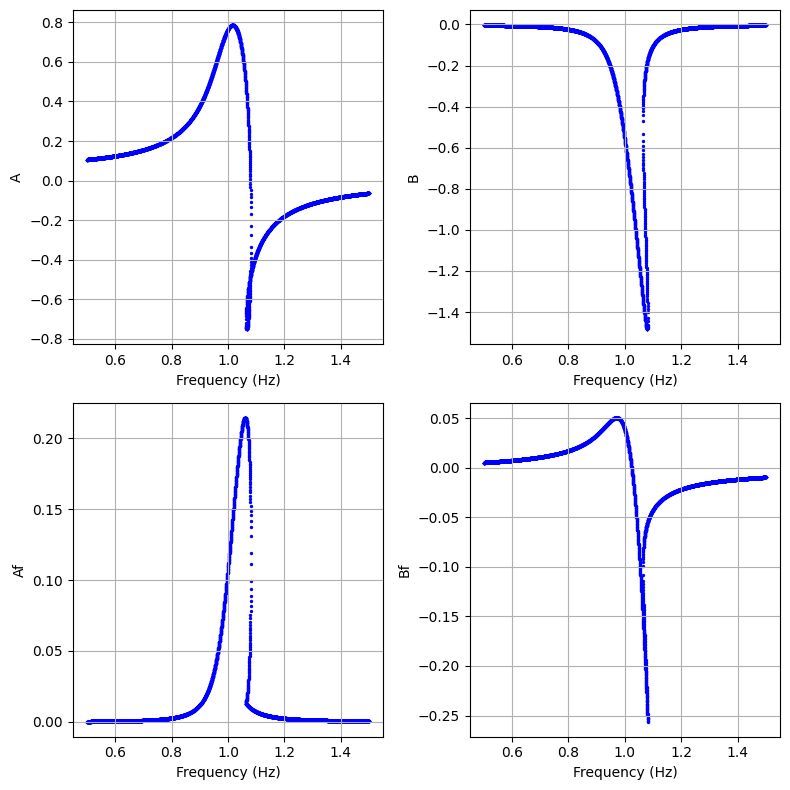

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))


axes[0, 0].scatter(X, A, color='blue', s=2)
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('A')
axes[0, 0].grid(True)



axes[0, 1].scatter(X, B, color='blue', s=2)
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('B')
axes[0, 1].grid(True)



axes[1, 0].scatter(X, Af, color='blue', s=2)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Af')
axes[1, 0].grid(True)


axes[1, 1].scatter(X, Bf, color='blue', s=2)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Bf')
axes[1, 1].grid(True)


plt.tight_layout()
plt.show();


In [13]:
X_train, X_test, train_idx, test_idx = train_test_split(X, np.arange(X.shape[0]), test_size=0.2, random_state=seed)

# Usar os índices para dividir A, B, Af e Bf
A_train, A_test = A[train_idx], A[test_idx]
B_train, B_test = B[train_idx], B[test_idx]
Af_train, Af_test = Af[train_idx], Af[test_idx]
Bf_train, Bf_test = Bf[train_idx], Bf[test_idx]

In [14]:
# Inicialize o MinMaxScaler
scaler_A = MinMaxScaler()
scaler_B = MinMaxScaler()
scaler_Af = MinMaxScaler()
scaler_Bf = MinMaxScaler()

# Redefina os dados para 2D, se necessário (aqui já está 2D conforme sua reshape)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
A_train = A_train.reshape(-1, 1)
A_test = A_test.reshape(-1, 1)
B_train = B_train.reshape(-1, 1)
B_test = B_test.reshape(-1, 1)
Af_train = Af_train.reshape(-1, 1)
Af_test = Af_test.reshape(-1, 1)
Bf_train = Bf_train.reshape(-1, 1)
Bf_test = Bf_test.reshape(-1, 1)

# Normalize os dados
A_train = scaler_A.fit_transform(A_train)
A_test = scaler_A.transform(A_test)

B_train = scaler_B.fit_transform(B_train)
B_test = scaler_B.transform(B_test)

Af_train = scaler_Af.fit_transform(Af_train)
Af_test = scaler_Af.transform(Af_test)

Bf_train = scaler_Bf.fit_transform(Bf_train)
Bf_test = scaler_Bf.transform(Bf_test)

# Converta arrays numpy normalizados para tensores PyTorch
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

A_train = torch.from_numpy(A_train.astype(np.float32))
A_test = torch.from_numpy(A_test.astype(np.float32))

B_train = torch.from_numpy(B_train.astype(np.float32))
B_test = torch.from_numpy(B_test.astype(np.float32))

Af_train = torch.from_numpy(Af_train.astype(np.float32))
Af_test = torch.from_numpy(Af_test.astype(np.float32))

Bf_train = torch.from_numpy(Bf_train.astype(np.float32))
Bf_test = torch.from_numpy(Bf_test.astype(np.float32))

# Se necessário, mova os dados para a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = X_train.to(device)
X_test = X_test.to(device)

A_train = A_train.to(device)
A_test = A_test.to(device)

B_train = B_train.to(device)
B_test = B_test.to(device)

Af_train = Af_train.to(device)
Af_test = Af_test.to(device)

Bf_train = Bf_train.to(device)
Bf_test = Bf_test.to(device)

##  Neural networks

In [15]:
class A_NN(nn.Module):
  def __init__(self, input_size, output_size):
        super(A_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20,15)
        self.output = nn.Linear(15, output_size)

  def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.output(x)
        return x


In [16]:
class B_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(B_NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 20)
        self.fc2 = nn.Linear(20,15)
        self.output = nn.Linear(15, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.output(x)
        return x


In [17]:
class Af_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Af_NN, self).__init__()
        self.fc1 = nn.Linear(3 * input_size, 15)  # Update input size to accept concatenated inputs
        self.fc2 = nn.Linear(15,15)
        self.output = nn.Linear(15, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.output(x)
        return x

In [18]:
class Bf_NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Bf_NN, self).__init__()
        self.fc1 = nn.Linear(3 * input_size, 15)  # Update input size to accept concatenated inputs
        self.fc2 = nn.Linear(15,15)
        self.output = nn.Linear(15, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.output(x)
        return x

### Loss functions

In [19]:
def loss_sin(X_array, A_pred, B_pred, Bf_pred):

    loss = -mu_v * B_pred * X_array**2 - zeta_v * A_pred * X_array + k_v * B_pred + Bf_pred
    #true = torch.zeros_like(loss)
    return torch.mean(torch.abs(loss))

In [20]:
def loss_cos(X_array, A_pred, B_pred, Af_pred):
    # Calcula a perda para a função cosseno
    loss = -mu_v * A_pred * X_array**2 + zeta_v * B_pred * X_array + k_v * A_pred + Af_pred - P_v
    #true = torch.zeros_like(loss)
    return torch.mean(torch.abs(loss))

In [21]:
def loss_mse(A_pred, B_pred, Af_pred, Bf_pred,A_true, B_true, Af_true,Bf_true):

    # Calcula a perda MSE para cada par de valores previstos e verdadeiros
    mse_loss_A = torch.nn.functional.mse_loss(A_pred, A_true)
    mse_loss_B = torch.nn.functional.mse_loss(B_pred, B_true)
    #mse_loss_Af = torch.nn.functional.mse_loss(Af_pred, Af_true)
    #mse_loss_Bf = torch.nn.functional.mse_loss(Bf_pred, Bf_true)

    # Soma as perdas para obter a perda total
    mse_loss = mse_loss_A + mse_loss_B #+ mse_loss_Af + mse_loss_Bf

    return mse_loss

In [22]:
input_size = 1  # Ajuste conforme necessário
output_size = 1  # Ajuste conforme necessário

A_model = A_NN(input_size, output_size)
B_model = B_NN(input_size, output_size)
Af_model = Af_NN(input_size, output_size)
Bf_model = Bf_NN(input_size, output_size)

# Definindo os parâmetros dos modelos
params = {
    'sin': list(A_model.parameters()) + list(B_model.parameters()) + list(Bf_model.parameters()),
    'cos': list(A_model.parameters()) + list(B_model.parameters()) + list(Af_model.parameters()),
    'mse': list(A_model.parameters()) + list(B_model.parameters()) + list(Af_model.parameters()) + list(Bf_model.parameters())
}

# Definindo os otimizadores e schedulers
learning_rate = 0.001
optimizers = {
    'sin': optim.Adam(params['sin'], lr=learning_rate),
    'cos': optim.Adam(params['cos'], lr=learning_rate),
    'mse': optim.Adam(params['mse'], lr=learning_rate)
}

schedulers = {
    'sin': ReduceLROnPlateau(optimizers['sin'], 'min', patience=25, factor=0.5, min_lr = 1e-7),
    'cos': ReduceLROnPlateau(optimizers['cos'], 'min', patience=25, factor=0.5, min_lr = 1e-7),
    'mse': ReduceLROnPlateau(optimizers['mse'], 'min', patience=25, factor=0.5, min_lr = 1e-7)
}

In [23]:

A_train = A_train.to(device)
Af_train = Af_train.to(device)
B_train = B_train.to(device)
Bf_train = Bf_train.to(device)
#t = t.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)

A_model = A_model.to(device)
Af_model = Af_model.to(device)
B_model = B_model.to(device)
Bf_model = Bf_model.to(device)

In [ ]:
num_epochs = int(1e4)
loss_array = []

loss_sin_array = []
loss_cos_array = []
loss_mse_array = []

learning_rates = []

coef_sin = 1
coef_cos = 1
coef_mse = 1

batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        A_batch = A_train[i:i + batch_size]
        Af_batch = Af_train[i:i + batch_size]
        B_batch = B_train[i:i + batch_size]
        Bf_batch = Bf_train[i:i + batch_size]

        A_predicted = A_model(X_batch)
        B_predicted = B_model(X_batch)

        Af_input = torch.cat((X_batch, A_predicted, B_predicted), dim=1)
        Bf_input = torch.cat((X_batch, A_predicted, B_predicted), dim=1)

        Af_predicted = Af_model(Af_input)
        Bf_predicted = Bf_model(Bf_input)

        loss_sin_v = coef_sin * loss_sin(X_batch, A_predicted, B_predicted, Bf_predicted)
        loss_cos_v = coef_cos * loss_cos(X_batch, A_predicted, B_predicted, Af_predicted)
        loss_mse_v = coef_mse * loss_mse(A_predicted, B_predicted, Af_predicted, Bf_predicted, A_batch, B_batch, Af_batch, Bf_batch)

        loss = coef_mse * loss_mse_v + coef_sin * loss_sin_v + coef_cos * loss_cos_v

        for key in optimizers:
            optimizers[key].zero_grad()
        loss.backward()
        for key in optimizers:
            optimizers[key].step()

    #schedulers['sin'].step(loss_sin_v)
    #schedulers['cos'].step(loss_cos_v)
    #schedulers['mse'].step(loss_mse_v)

    loss_array.append(loss.item())
    loss_sin_array.append(loss_sin_v.item())
    loss_cos_array.append(loss_cos_v.item())
    loss_mse_array.append(loss_mse_v.item())
    learning_rates.append({
        'sin': optimizers['sin'].param_groups[0]['lr'],
        'cos': optimizers['cos'].param_groups[0]['lr'],
        'mse': optimizers['mse'].param_groups[0]['lr']
    })

    if (epoch + 1) % 10 == 0:
        print(f'#### epoch: {epoch + 1}, loss = {loss.item()} ####')
        print("Loss Sin: ", loss_sin_v.item())
        print("Loss Cos: ", loss_cos_v.item())
        print("Loss MSE: ", loss_mse_v.item())

#### epoch: 10, loss = 0.08931523561477661 ####
Loss Sin:  0.008548730984330177
Loss Cos:  0.0034316317178308964
Loss MSE:  0.07733487337827682
#### epoch: 20, loss = 0.08589041233062744 ####
Loss Sin:  0.0062310099601745605
Loss Cos:  0.0026945241261273623
Loss MSE:  0.07696487754583359
#### epoch: 30, loss = 0.08508546650409698 ####
Loss Sin:  0.00902564451098442
Loss Cos:  0.0012934979749843478
Loss MSE:  0.07476632297039032
#### epoch: 40, loss = 0.09239573776721954 ####
Loss Sin:  0.013781154528260231
Loss Cos:  0.0036850639153271914
Loss MSE:  0.07492952048778534
#### epoch: 50, loss = 0.08608578145503998 ####
Loss Sin:  0.012773867696523666
Loss Cos:  0.0012189719127491117
Loss MSE:  0.0720929428935051
#### epoch: 60, loss = 0.07519057393074036 ####
Loss Sin:  0.003095878753811121
Loss Cos:  0.0018533007241785526
Loss MSE:  0.07024139165878296
#### epoch: 70, loss = 0.08044357597827911 ####
Loss Sin:  0.004443802405148745
Loss Cos:  0.004592405166476965
Loss MSE:  0.071407370269

In [ ]:
# Extraindo as taxas de aprendizado para plotagem
learning_rates_sin = [lr['sin'] for lr in learning_rates]
learning_rates_cos = [lr['cos'] for lr in learning_rates]
learning_rates_mse = [lr['mse'] for lr in learning_rates]

# Plotando as taxas de aprendizado
plt.plot(learning_rates_sin, label='Learning Rate Sin')
plt.plot(learning_rates_cos, label='Learning Rate Cos')
plt.plot(learning_rates_mse, label='Learning Rate MSE')

plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.title('Learning Rate ao longo das Épocas')
plt.legend()
plt.show()

# Exibindo a última taxa de aprendizado de cada scheduler
print('Última Learning Rate Sin:', learning_rates_sin[-1])
print('Última Learning Rate Cos:', learning_rates_cos[-1])
print('Última Learning Rate MSE:', learning_rates_mse[-1])

In [ ]:
plt.figure(figsize=(10, 8))

# Plotando todas as perdas no mesmo gráfico
plt.plot(loss_array, label='Total Loss')
plt.plot(loss_sin_array, label='Sin Loss')
plt.plot(loss_cos_array, label='Cos Loss')
plt.plot(loss_mse_array, label='MSE Loss')

# Configurando o gráfico
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over Epochs (Log Scale)')
plt.legend()  # Adiciona a legenda

# Exibindo o último valor de loss
print(f'Total Loss: {loss_array[-1]}')
print(f'Sin Loss: {loss_sin_array[-1]}')
print(f'Cos Loss: {loss_cos_array[-1]}')
print(f'MSE Loss: {loss_mse_array[-1]}')

# Exibindo o gráfico
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))

# Plotando todas as perdas no mesmo gráfico
plt.plot(loss_array, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss over Epochs (Log Scale)')
#plt.xlim(400,500)
plt.legend()  # Adiciona a legenda

plt.show()

In [ ]:
# Predição
A_predicted = A_model(X_test).detach().cpu().numpy()



# Plotagem
plt.figure(figsize=(10, 8))
plt.scatter(X_test.cpu().numpy(), A_predicted, label="Predicted Values")  # Converta X_test para numpy
plt.scatter(X_test.cpu().numpy(), A_test.cpu().numpy(), label="Test data")  # Converta A_test para numpy
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("A")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Predição
B_predicted = B_model(X_test).detach().cpu().numpy()

# Plotagem
plt.figure(figsize=(10, 8))
plt.scatter(X_test.cpu().numpy(), B_predicted, label="Predicted Values")  # Converta X_test para numpy
plt.scatter(X_test.cpu().numpy(), B_test.cpu().numpy(), label="Test data")  # Converta A_test para numpy
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("B")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
 #Obtendo as predições de B_model e A_model
B_predicted = B_model(X_test).detach().cpu()
A_predicted = A_model(X_test).detach().cpu()

# Coloca o modelo Af_model em modo de avaliação
Af_model.eval()

# Desabilita o cálculo do gradiente
with torch.no_grad():
    # Cria as entradas para Af_model e move para o mesmo dispositivo
    X_test = X_test.to(device)
    A_test = A_test.to(device)
    B_test = B_test.to(device)
    Af_pred_input = torch.cat((X_test, A_test, B_test), dim=1).to(device)

    # Realiza a predição e converte para numpy
    Af_predicted = Af_model(Af_pred_input).detach().cpu().numpy()

# Plotagem
plt.figure(figsize=(10, 8))

# Converta X_test e Af_test para numpy se ainda não estiverem
X_test_np = X_test.cpu().numpy() if not isinstance(X_test, np.ndarray) else X_test
Af_test_np = Af_test.cpu().numpy() if not isinstance(Af_test, np.ndarray) else Af_test

plt.scatter(X_test_np, Af_predicted, label="Predicted Values")
plt.scatter(X_test_np, Af_test_np, label="Test Data")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("Af")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Bf_model.eval()

# Desabilita o cálculo do gradiente
with torch.no_grad():
    # Cria as entradas para Bf_model e move para o mesmo dispositivo
    Bf_pred_input = torch.cat((X_test, A_test, B_test), dim=1)

    # Realiza a predição e converte para numpy
    Bf_predicted = Bf_model(Bf_pred_input).detach().cpu().numpy()


# Plotagem
plt.figure(figsize=(10, 8))

# Converte X_test e Bf_test para numpy se ainda não estiverem
X_test_np = X_test.cpu().numpy() if not isinstance(X_test, np.ndarray) else X_test
Bf_test_np = Bf_test.cpu().numpy() if not isinstance(Bf_test, np.ndarray) else Bf_test

plt.scatter(X_test_np, Bf_predicted, label="Predicted Values")
plt.scatter(X_test_np, Bf_test_np, label="Test Data")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Error (Normalized)')
plt.title("Bf")
plt.grid(True)
plt.legend()
plt.show()